## Configuration of colab environment

In [1]:
# Mounting drive
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [0]:
# Loading libraries
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision

In [3]:
!pip install Pillow==4.1.0
!pip install PIL
!pip install Image

  Using cached https://files.pythonhosted.org/packages/e7/14/ce7a5cc750ae3a8506d57997d4f18a0674fe45dd843882b9580f06b6d8f1/Pillow-4.1.0-cp36-cp36m-manylinux1_x86_64.whl
torchvision 0.2.1 has requirement pillow>=4.1.1, but you'll have pillow 4.1.0 which is incompatible.
  Found existing installation: Pillow 5.4.1
    Uninstalling Pillow-5.4.1:
      Successfully uninstalled Pillow-5.4.1
  Could not find a version that satisfies the requirement PIL (from versions: )
No matching distribution found for PIL


## Importing libraries

In [0]:
import cv2
import torch
from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt

from time import time
from copy import deepcopy
from matplotlib import gridspec
from torchvision import datasets, models, transforms

## Setting parameters

In [0]:
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Model parameters
batch_size = 4
num_classes = 4
num_epochs = 20
input_size = 224

# root path to drive
root_path = 'gdrive/My Drive/'

## Loading data

In [0]:
class ImageFolderWithPath(datasets.ImageFolder):    
    def __getitem__(self, index):
        """
        Args:
            index (int): Index
        Returns:
            tuple: (sample, target) where target is class_index of the target class.
        """
        path, target = self.samples[index]
        sample = self.loader(path)
        if self.transform is not None:
            sample = self.transform(sample)
        if self.target_transform is not None:
            target = self.target_transform(target)

        return sample, target, path

In [0]:
transform = transforms.Compose([
        transforms.Resize([input_size, input_size]),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])

In [0]:
data_dir = root_path+'Fotos - Side Project/depth'

dataset = ImageFolderWithPath(data_dir, transform) # custom dataset

## Stratified Splitting Dataset

In [0]:
x = [idx for idx in range(len(dataset.imgs))]
y = [dataset.imgs[idx][1] for idx in range(len(dataset.imgs))]

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=6, shuffle=True, stratify = y)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, random_state=6, shuffle=True, stratify = y_train)

In [0]:
image_datasets = { 'train': torch.utils.data.Subset(dataset, torch.tensor(x_train)),
                   'valid': torch.utils.data.Subset(dataset, torch.tensor(x_valid)),
                   'test': torch.utils.data.Subset(dataset, torch.tensor(x_test)) }

In [0]:
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x],
                                                   batch_size=batch_size,
                                                   shuffle=True,
                                                   num_workers=4) \
                    for x in image_datasets.keys()}

## Initializing Model

In [0]:
# densenet_201
def initialize_model():
    model_name = 'densenet_201'
    model = models.densenet201(pretrained=True)
    model.classifier = torch.nn.Sequential(torch.nn.Linear(model.classifier.in_features, 500),
                                          torch.nn.ReLU(),
                                          torch.nn.Linear(500, num_classes),
                                          torch.nn.LogSoftmax(dim=1))

    # Send the model to GPU
    model = model.to(device)

    #optimizer = torch.optim.SGD(model.classifier.parameters(), lr=0.001, momentum=0.9)
    optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.001)
    #criterion = torch.nn.CrossEntropyLoss()
    criterion = torch.nn.NLLLoss()
    
    return model, optimizer, criterion, model_name

## Training Model

In [0]:
# Defining train_model function
def train_model(model, model_name, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time()

    best_model_wts = deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels, _ in dataloaders_dict[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss

                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                print('Accuracy increased ({:.6f} --> {:.6f}).'.format(
                best_acc, epoch_acc))
                best_acc = epoch_acc
                best_model_wts = deepcopy(model.state_dict())

        # stop training if accuracy equals to 1.0
        if epoch_acc == 1.0:
            break
        print()

    time_elapsed = time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [14]:
model, optimizer, criterion, model_name = initialize_model()
model = train_model(model, model_name, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)
model_path = f'{root_path}/model_{model_name}.pth'

torch.save(model.state_dict(), model_path)

/usr/local/lib/python3.6/dist-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


Epoch 1/20
----------
train Loss: 1.3243 Acc: 0.4074
valid Loss: 1.2377 Acc: 0.4444
Accuracy increased (0.000000 --> 0.444444).

Epoch 2/20
----------
train Loss: 0.8619 Acc: 0.6296
valid Loss: 0.9458 Acc: 0.6667
Accuracy increased (0.444444 --> 0.666667).

Epoch 3/20
----------
train Loss: 0.9225 Acc: 0.6296
valid Loss: 0.9496 Acc: 0.5556

Epoch 4/20
----------
train Loss: 0.6780 Acc: 0.7778
valid Loss: 0.7520 Acc: 0.6667

Epoch 5/20
----------
train Loss: 0.6249 Acc: 0.7037
valid Loss: 0.6635 Acc: 0.8889
Accuracy increased (0.666667 --> 0.888889).

Epoch 6/20
----------
train Loss: 0.3831 Acc: 0.8519
valid Loss: 0.6033 Acc: 0.8889

Epoch 7/20
----------
train Loss: 0.3888 Acc: 0.8519
valid Loss: 0.5188 Acc: 0.7778

Epoch 8/20
----------
train Loss: 0.2391 Acc: 0.9259
valid Loss: 0.4966 Acc: 1.0000
Accuracy increased (0.888889 --> 1.000000).
Training complete in 0m 20s
Best val Acc: 1.000000


## Loading Model

In [0]:
model.load_state_dict(torch.load(model_path))

## Predicting

In [16]:
# track test loss 
classes = dataset.classes
testloader = dataloaders_dict['test']
test_loss = 0.0
class_correct = list(0. for i in range(4))
class_total = list(0. for i in range(4))

model.eval()

# iterate over test data
# only works for even lengths of testloader
for data, target, _ in testloader:
    data, target = data.to(device), target.to(device)
    output = model(data)
    loss = criterion(output, target)
    test_loss += loss.item()*data.size(0)
    _, pred = torch.max(output, 1)    
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    for i in range(batch_size):
        label = target.data[i]
        class_correct[int(label)] += correct[i].item()
        class_total[int(label)] += 1

# calculate avg test loss
test_loss = test_loss/len(testloader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(4):
    if class_total[i] > 0:
        print('Test Accuracy of %4s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %4s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.603911

Test Accuracy of Dulce: 100% ( 2/ 2)
Test Accuracy of Igor: 50% ( 1/ 2)
Test Accuracy of Lais: 100% ( 6/ 6)
Test Accuracy of Walnei: 50% ( 1/ 2)

Test Accuracy (Overall): 83% (10/12)


## Sanity Checking

In [0]:
def view_classify(img, ps, num_classes, path, label):
  
  ps = ps.data.numpy().squeeze()
  
  fig = plt.figure(1)
  gridspec.GridSpec(1,3)

  # original image
  plt.subplot2grid((1,3), (0,0))
  plt.imshow(cv2.imread(path.replace('depth', '2d')))
  plt.title(f'Original Label: {classes[label]}')
  plt.axis('off')

  # depth image
  plt.subplot2grid((1,3), (0,1))
  plt.imshow(cv2.imread(path), 'gray')
  plt.title('Depth Image')
  plt.axis('off')

  # class probabilities
  plt.subplot2grid((1,3), (0,2))
  plt.barh(np.arange(num_classes), ps)
  plt.yticks(np.arange(num_classes), classes)
  xticks = [0.0, 0.25, 0.5, 0.75, 1]
  plt.xticks(xticks, [int(x*100) for x in xticks])
  plt.title('Class Probabilities')
  plt.xlabel('Probabilities (%)')
  plt.ylabel('Class (person)')
  plt.xlim(0, 1)

  # fit subplots and save fig
  fig.tight_layout()
  fig.set_size_inches(w=10,h=4)

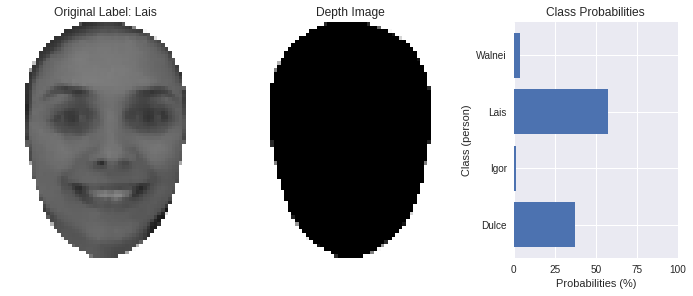

In [18]:
# obtain one batch of test images
dataiter = iter(testloader)
images, labels, path = dataiter.next()
img = images[1]
img = img.view(1, img.shape[0], img.shape[1], img.shape[2])
img = img.to(device)

# get sample outputs
outputs = model(img)
ps = torch.exp(outputs)

view_classify(img.cpu(), ps.cpu(), num_classes, path[1], labels[1])